In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']


In [3]:
from pycaret.regression import RegressionExperiment
import pickle
import json
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

from heisenberg_graph import (
    extract_probs,
)

In [4]:
# Only for CP1
%cd fourier_learning_ibm/

/home/jovyan/fourier_learning_ibm


In [5]:
# Load parameters
CURRENT_TIME = "2024-12-02T09:24Z"
path = f"./data/{CURRENT_TIME}"

# Load the graphs as a binary file
with open(f"{path}/params_object.pkl", "rb") as f:
    params_object = pickle.load(f)

graphs = params_object["graphs"]
all_Js = params_object["Js"]
all_expected_values = params_object["expected_values"]

for key, value in params_object.items():
    print(f"{key}: {value}")

# Load the parameters as a JSON file
with open(f"{path}/params_text.json", "r") as f:
    params = json.load(f)

n_samples = params["n_samples"]
n_qubits = params["n_qubits"]
graph_type = params["graph_type"]
backend_qpu_name = params["backend_qpu_name"]
beta = params["beta"]
C = params["C"]
n_features = params["n_features"]
times = params["times"]

for key, value in params.items():
    print(f"{key}: {value}")

graphs: [<networkx.classes.graph.Graph object at 0x7fb6d43ab750>, <networkx.classes.graph.Graph object at 0x7fb6f275bf10>, <networkx.classes.graph.Graph object at 0x7fb6d43b0d50>, <networkx.classes.graph.Graph object at 0x7fb6d43b1710>, <networkx.classes.graph.Graph object at 0x7fb6d43b20d0>, <networkx.classes.graph.Graph object at 0x7fb6d43b2a90>, <networkx.classes.graph.Graph object at 0x7fb6d43b3450>, <networkx.classes.graph.Graph object at 0x7fb6d43b3e10>, <networkx.classes.graph.Graph object at 0x7fb6d43c0810>, <networkx.classes.graph.Graph object at 0x7fb6d43c11d0>, <networkx.classes.graph.Graph object at 0x7fb6d43c1b90>, <networkx.classes.graph.Graph object at 0x7fb6d43c2550>, <networkx.classes.graph.Graph object at 0x7fb6d43c2f10>, <networkx.classes.graph.Graph object at 0x7fb6d43c38d0>, <networkx.classes.graph.Graph object at 0x7fb6d41cc2d0>, <networkx.classes.graph.Graph object at 0x7fb6d41ccc90>, <networkx.classes.graph.Graph object at 0x7fb6d41cd650>, <networkx.classes.grap

## Plot probability

In [6]:
# Load the data as a json file
with open(f"{path}/probs_phase0_exact.json", "r") as f:
    probs_phase0_exact = json.load(f)
with open(f"{path}/probs_phase1_exact.json", "r") as f:
    probs_phase1_exact = json.load(f)
with open(f"{path}/probs_phase2_exact.json", "r") as f:
    probs_phase2_exact = json.load(f)
with open(f"{path}/probs_phase3_exact.json", "r") as f:
    probs_phase3_exact = json.load(f)

In [7]:
with open(f"{path}/probs_phase0_sim.json", "r") as f:
    probs_phase0_sim = json.load(f)
with open(f"{path}/probs_phase1_sim.json", "r") as f:
    probs_phase1_sim = json.load(f)
with open(f"{path}/probs_phase2_sim.json", "r") as f:
    probs_phase2_sim = json.load(f)
with open(f"{path}/probs_phase3_sim.json", "r") as f:
    probs_phase3_sim = json.load(f)

In [8]:
with open(f"{path}/probs_phase0_sim_noisy.json", "r") as f:
    probs_phase0_sim_noisy = json.load(f)
with open(f"{path}/probs_phase1_sim_noisy.json", "r") as f:
    probs_phase1_sim_noisy = json.load(f)
with open(f"{path}/probs_phase2_sim_noisy.json", "r") as f:
    probs_phase2_sim_noisy = json.load(f)
with open(f"{path}/probs_phase3_sim_noisy.json", "r") as f:
    probs_phase3_sim_noisy = json.load(f)

In [9]:
with open(f"{path}/probs_phase0_nmit.json", "r") as f:
    probs_phase0_nmit = json.load(f)
with open(f"{path}/probs_phase1_nmit.json", "r") as f:
    probs_phase1_nmit = json.load(f)
with open(f"{path}/probs_phase2_nmit.json", "r") as f:
    probs_phase2_nmit = json.load(f)
with open(f"{path}/probs_phase3_nmit.json", "r") as f:
    probs_phase3_nmit = json.load(f)

with open(f"{path}/probs_phase0_mit.json", "r") as f:
    probs_phase0_mit = json.load(f)
with open(f"{path}/probs_phase1_mit.json", "r") as f:
    probs_phase1_mit = json.load(f)
with open(f"{path}/probs_phase2_mit.json", "r") as f:
    probs_phase2_mit = json.load(f)
with open(f"{path}/probs_phase3_mit.json", "r") as f:
    probs_phase3_mit = json.load(f)

In [10]:
with open(f"{path}/successful_job_ids_and_samples.json", "r") as f:
    successful_job_ids_and_samples = json.load(f)

In [11]:
# For debugging
dummy_successful_job_ids_and_samples = {}
for i in range(n_samples):
    dummy_successful_job_ids_and_samples[f"sample{i}"] = None

successful_job_ids_and_samples = dummy_successful_job_ids_and_samples

In [12]:
probs_phase0_exact_extracted = extract_probs(
    probs_phase0_exact, successful_job_ids_and_samples.keys()
)
probs_phase1_exact_extracted = extract_probs(
    probs_phase1_exact, successful_job_ids_and_samples.keys()
)
probs_phase2_exact_extracted = extract_probs(
    probs_phase2_exact, successful_job_ids_and_samples.keys()
)
probs_phase3_exact_extracted = extract_probs(
    probs_phase3_exact, successful_job_ids_and_samples.keys()
)

In [13]:
probs_phase0_sim_extracted = extract_probs(
    probs_phase0_sim, successful_job_ids_and_samples.keys()
)
probs_phase1_sim_extracted = extract_probs(
    probs_phase1_sim, successful_job_ids_and_samples.keys()
)
probs_phase2_sim_extracted = extract_probs(
    probs_phase2_sim, successful_job_ids_and_samples.keys()
)
probs_phase3_sim_extracted = extract_probs(
    probs_phase3_sim, successful_job_ids_and_samples.keys()
)

In [14]:
probs_phase0_sim_noisy_extracted = extract_probs(
    probs_phase0_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase1_sim_noisy_extracted = extract_probs(
    probs_phase1_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase2_sim_noisy_extracted = extract_probs(
    probs_phase2_sim_noisy, successful_job_ids_and_samples.keys()
)
probs_phase3_sim_noisy_extracted = extract_probs(
    probs_phase3_sim_noisy, successful_job_ids_and_samples.keys()
)

In [15]:
probs_phase0_nmit_extracted = extract_probs(
    probs_phase0_nmit, successful_job_ids_and_samples.keys()
)
probs_phase1_nmit_extracted = extract_probs(
    probs_phase1_nmit, successful_job_ids_and_samples.keys()
)
probs_phase2_nmit_extracted = extract_probs(
    probs_phase2_nmit, successful_job_ids_and_samples.keys()
)
probs_phase3_nmit_extracted = extract_probs(
    probs_phase3_nmit, successful_job_ids_and_samples.keys()
)

probs_phase0_mit_extracted = extract_probs(
    probs_phase0_mit, successful_job_ids_and_samples.keys()
)
probs_phase1_mit_extracted = extract_probs(
    probs_phase1_mit, successful_job_ids_and_samples.keys()
)
probs_phase2_mit_extracted = extract_probs(
    probs_phase2_mit, successful_job_ids_and_samples.keys()
)
probs_phase3_mit_extracted = extract_probs(
    probs_phase3_mit, successful_job_ids_and_samples.keys()
)

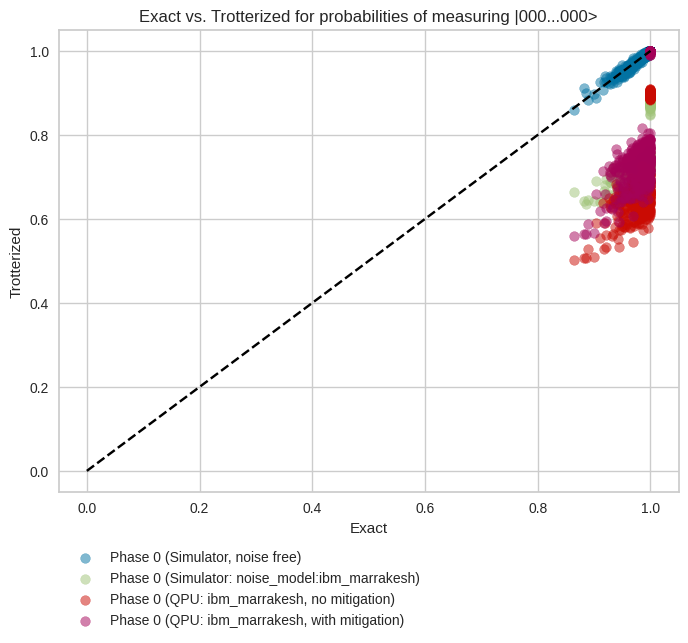

In [16]:
# Plot exact vs. Trotterized results
plt.figure(figsize=(8, 6))
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_extracted,
    label=f"Phase 0 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_sim_noisy_extracted,
    label=f"Phase 0 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_nmit_extracted,
    label=f"Phase 0 (QPU: {backend_qpu_name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase0_exact_extracted,
    probs_phase0_mit_extracted,
    label=f"Phase 0 (QPU: {backend_qpu_name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

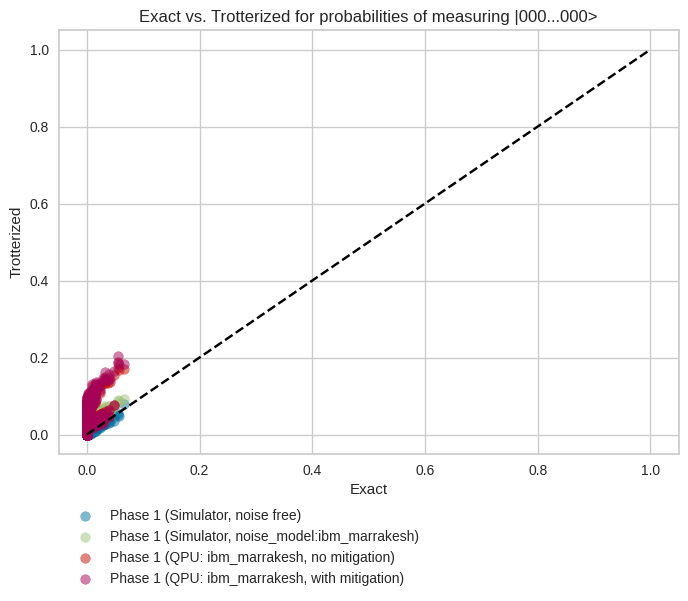

In [17]:
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_extracted,
    label=f"Phase 1 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_sim_noisy_extracted,
    label=f"Phase 1 (Simulator, noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_nmit_extracted,
    label=f"Phase 1 (QPU: {backend_qpu_name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase1_exact_extracted,
    probs_phase1_mit_extracted,
    label=f"Phase 1 (QPU: {backend_qpu_name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

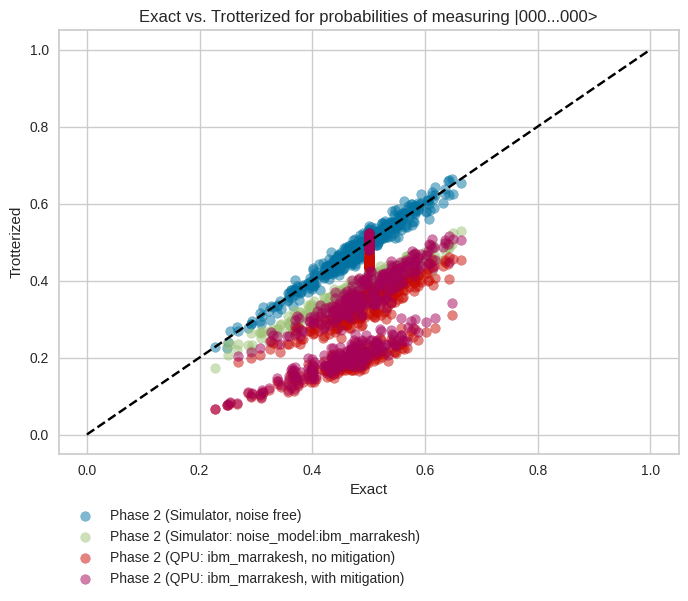

In [18]:
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_extracted,
    label=f"Phase 2 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_sim_noisy_extracted,
    label=f"Phase 2 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_nmit_extracted,
    label=f"Phase 2 (QPU: {backend_qpu_name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase2_exact_extracted,
    probs_phase2_mit_extracted,
    label=f"Phase 2 (QPU: {backend_qpu_name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")

plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

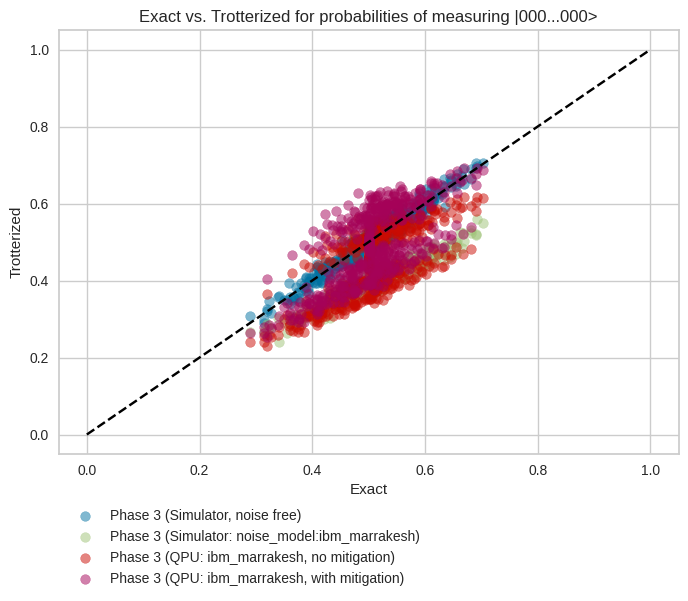

In [19]:
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_extracted,
    label=f"Phase 3 (Simulator, noise free)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_sim_noisy_extracted,
    label=f"Phase 3 (Simulator: noise_model:{backend_qpu_name})",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_nmit_extracted,
    label=f"Phase 3 (QPU: {backend_qpu_name}, no mitigation)",
    alpha=0.5,
)
plt.scatter(
    probs_phase3_exact_extracted,
    probs_phase3_mit_extracted,
    label=f"Phase 3 (QPU: {backend_qpu_name}, with mitigation)",
    alpha=0.5,
)
# Plot the 1:1 line
plt.plot([0, 1], [0, 1], "--", color="black")
plt.xlabel("Exact")
plt.ylabel("Trotterized")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.title("Exact vs. Trotterized for probabilities of measuring |000...000>")
plt.show()

## Regression

In [20]:
data_exact_df = pd.read_json(f"{path}/data_exact_df.json")

In [21]:
data_sim_df = pd.read_json(f"{path}/data_sim_df.json")

In [22]:
data_sim_noisy_df = pd.read_json(f"{path}/data_sim_noisy_df.json")

In [23]:
data_nmit_df = pd.read_json(f"{path}/data_qpu_nmit_df.json")
data_mit_df = pd.read_json(f"{path}/data_qpu_mit_df.json")

In [24]:
# For debugging
# data_mit_df = data_exact_df

In [25]:
# Extract features which have overlap with data_mit_df (i.e. successful samples)
data_exact_df = data_exact_df[data_exact_df.index.isin(data_mit_df.sample_id)]

In [26]:
data_sim_df = data_sim_df[data_sim_df.index.isin(data_mit_df.sample_id)]

In [27]:
data_sim_noisy_df = data_sim_noisy_df[
    data_sim_noisy_df.index.isin(data_mit_df.sample_id)
]

In [28]:
data_nmit_df = data_nmit_df[data_nmit_df.index.isin(data_mit_df.sample_id)]

In [29]:
print("Exact")
display(data_exact_df)

Exact


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1,0.996941,-0.021182,0.987812,-0.041879,0.972755,-0.061616,0.952003,-0.079948,2.349069
1,1,1,0.994417,-0.084961,0.977772,-0.168494,0.950368,-0.249200,0.912704,-0.325731,0.801446
2,2,1,0.998612,-0.022648,0.994457,-0.045169,0.987562,-0.067437,0.977969,-0.089325,1.401454
3,3,1,0.999344,-0.008507,0.997379,-0.016955,0.994120,-0.025286,0.989588,-0.033445,1.179205
4,4,1,0.997933,-0.025646,0.991765,-0.050839,0.981590,-0.075134,0.967564,-0.098100,1.121292
...,...,...,...,...,...,...,...,...,...,...,...
103,103,1,0.997535,0.036264,0.990166,0.072380,0.977970,0.108198,0.961077,0.143564,5.071432
104,104,1,0.999175,0.019264,0.996705,0.038472,0.992609,0.057569,0.986913,0.076502,2.536326
105,105,1,0.997997,0.033793,0.992007,0.067440,0.982089,0.100798,0.968341,0.133718,4.458616
106,106,1,0.996319,0.048269,0.985321,0.096200,0.967140,0.143451,0.941994,0.189683,7.820448


In [30]:
print("Simulator (noise free)")
display(data_sim_df)

Simulator (noise free)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,1,0.998071,-0.031530,0.993593,-0.049453,0.976799,-0.038686,0.953132,-0.097080,2.349069
1,1,1,0.993240,-0.082332,0.978283,-0.169554,0.948136,-0.262947,0.915999,-0.299850,0.801446
2,2,1,0.999012,-0.022966,0.997013,-0.057649,0.989113,-0.096227,0.980293,-0.087920,1.401454
3,3,1,0.997027,-0.011013,0.994713,-0.028791,0.996991,-0.007631,0.993185,-0.047752,1.179205
4,4,1,1.001722,-0.042657,0.990228,-0.062092,0.979798,-0.094583,0.967027,-0.134063,1.121292
...,...,...,...,...,...,...,...,...,...,...,...
103,103,1,1.000429,0.008386,1.012120,0.015201,0.973590,0.120786,0.963059,0.138361,5.071432
104,104,1,0.998091,0.045276,0.995238,0.014151,0.992070,0.027766,0.986309,0.070399,2.536326
105,105,1,0.996856,0.051179,0.994956,0.065169,0.976323,0.118542,0.965291,0.113892,4.458616
106,106,1,0.997076,-0.002161,0.983704,0.099363,0.953438,0.115426,0.939879,0.206677,7.820448


In [31]:
print("Simulator (noisy)")
display(data_sim_noisy_df)

Simulator (noisy)


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.885742,0.675436,0.012090,0.686971,-0.045518,0.687695,-0.046915,0.667627,-0.022341,2.349069
1,1,0.861328,0.702509,-0.029831,0.686715,-0.111224,0.688187,-0.178733,0.621642,-0.227991,0.801446
2,2,0.884766,0.688464,-0.025739,0.693335,-0.024139,0.666954,-0.025426,0.701048,-0.061965,1.401454
3,3,0.868164,0.665340,0.012181,0.681133,0.002345,0.682812,-0.032737,0.679584,-0.024535,1.179205
4,4,0.875977,0.703007,-0.005446,0.682686,0.004945,0.661330,-0.036751,0.693755,-0.047973,1.121292
...,...,...,...,...,...,...,...,...,...,...,...
103,103,0.875000,0.685028,0.013361,0.693212,0.056260,0.724481,0.045077,0.679823,0.125315,5.071432
104,104,0.875000,0.734643,0.034005,0.692602,0.018455,0.684820,0.029899,0.698256,0.075085,2.536326
105,105,0.860352,0.683857,0.032201,0.682067,0.059471,0.692417,0.073337,0.668398,0.058451,4.458616
106,106,0.883789,0.705451,0.059185,0.690258,0.061916,0.655547,0.115982,0.648167,0.141492,7.820448


In [32]:
print("no mitigation")
display(data_nmit_df)

print("mitigation")
display(data_mit_df)

no mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.999547,0.770891,-0.068448,0.781865,-0.095197,0.754217,-0.121768,0.732206,-0.131522,2.349069
1,1,0.996800,0.680183,-0.420971,0.605972,-0.477208,0.564426,-0.509855,0.508838,-0.572897,0.801446
2,2,0.995583,0.690874,-0.349782,0.674338,-0.368676,0.638040,-0.393899,0.642073,-0.399981,1.401454
3,3,1.000000,0.710184,-0.096861,0.707849,-0.101772,0.715745,-0.114667,0.706762,-0.120890,1.179205
4,4,1.000000,0.669674,-0.382950,0.643002,-0.389706,0.651797,-0.400999,0.610427,-0.415409,1.121292
...,...,...,...,...,...,...,...,...,...,...,...
103,103,1.000000,0.768202,0.033795,0.745931,0.068713,0.746710,0.081659,0.728362,0.108659,5.071432
104,104,1.000000,0.695095,-0.380637,0.679436,-0.383368,0.697725,-0.359200,0.669179,-0.356386,2.536326
105,105,1.000000,0.769190,0.035838,0.748562,0.062302,0.747298,0.078683,0.748758,0.104627,4.458616
106,106,1.000000,0.742874,0.036858,0.726164,0.070483,0.739016,0.123724,0.697954,0.150650,7.820448


mitigation


,sample_id,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value
0,0,0.897705,0.678265,-0.059955,0.687964,-0.083857,0.663802,-0.107513,0.644010,-0.116073,2.349069
1,1,0.890137,0.598928,-0.369859,0.533439,-0.420125,0.496842,-0.448612,0.448328,-0.504283,0.801446
2,2,0.887207,0.608487,-0.307925,0.594154,-0.324820,0.561730,-0.346800,0.565451,-0.351975,1.401454
3,3,0.892334,0.626340,-0.084829,0.624542,-0.089054,0.631198,-0.100762,0.623156,-0.106110,1.179205
4,4,0.894287,0.590219,-0.337170,0.566662,-0.343257,0.574451,-0.353263,0.538485,-0.365751,1.121292
...,...,...,...,...,...,...,...,...,...,...,...
103,103,0.894531,0.676820,0.030317,0.657049,0.061174,0.657683,0.072480,0.641520,0.096380,5.071432
104,104,0.900879,0.611990,-0.335295,0.598463,-0.337333,0.614312,-0.316480,0.589293,-0.314101,2.536326
105,105,0.891113,0.677287,0.031478,0.659402,0.054671,0.657756,0.069126,0.659364,0.092178,4.458616
106,106,0.888916,0.654509,0.032883,0.639477,0.062290,0.650784,0.109232,0.614724,0.132050,7.820448


## Exact

In [46]:
train_size = 0.8
session_id = 42

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(108, 11)"
4,Transformed data shape,"(108, 10)"
5,Transformed train set shape,"(86, 10)"
6,Transformed test set shape,"(22, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.2724,0.1598,0.3772,0.9748,0.1114,0.2196,0.0130
huber,Huber Regressor,0.9911,2.8713,1.4593,0.7724,0.2552,0.4239,0.0110
et,Extra Trees Regressor,1.1302,3.0769,1.6422,0.6864,0.3508,0.5458,0.0420
gbr,Gradient Boosting Regressor,1.1398,3.3540,1.6138,0.7202,0.3330,0.5372,0.0150
rf,Random Forest Regressor,1.2133,3.3541,1.6559,0.7136,0.3667,0.6236,0.0550
lightgbm,Light Gradient Boosting Machine,1.4019,4.0492,1.9321,0.5854,0.4250,0.9704,0.1990
ada,AdaBoost Regressor,1.5380,4.4251,1.9702,0.4348,0.4688,1.1941,0.0150
dt,Decision Tree Regressor,1.3733,4.9966,1.9950,0.5631,0.4214,0.6324,0.0110
knn,K Neighbors Regressor,1.5698,5.5563,2.1283,0.5633,0.4324,0.7710,0.0160
ridge,Ridge Regression,2.2019,8.2616,2.7714,0.1566,0.5367,1.2710,0.0110


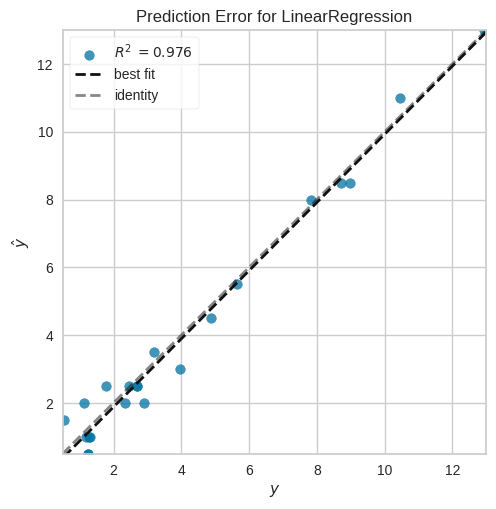

In [47]:
s_exact = RegressionExperiment()
s_exact.setup(
    data=data_exact_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_exact = s_exact.compare_models(turbo=True, sort="MSE")

s_exact.plot_model(best_exact, plot="error")

## Trotter (Simulation, Noise free)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(108, 11)"
4,Transformed data shape,"(108, 10)"
5,Transformed train set shape,"(86, 10)"
6,Transformed test set shape,"(22, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.3153,3.7376,1.7882,0.6528,0.3687,0.7150,0.0440
rf,Random Forest Regressor,1.3747,3.8740,1.8092,0.6608,0.3910,0.8128,0.0570
lightgbm,Light Gradient Boosting Machine,1.4655,3.9535,1.8754,0.6525,0.4432,1.0449,0.2060
br,Bayesian Ridge,1.5008,4.3005,1.9380,0.4163,0.3860,0.9295,0.0100
huber,Huber Regressor,1.4715,4.3404,1.9371,0.4210,0.3809,0.8928,0.0130
lr,Linear Regression,1.5445,4.5038,2.0032,0.4113,0.3925,0.8915,0.0110
lar,Least Angle Regression,1.5445,4.5038,2.0032,0.4113,0.3925,0.8915,0.0120
ada,AdaBoost Regressor,1.6955,4.8546,2.1087,0.4712,0.4994,1.3278,0.0170
gbr,Gradient Boosting Regressor,1.4740,4.8923,2.0302,0.5728,0.4127,0.7140,0.0150
knn,K Neighbors Regressor,1.6217,5.7749,2.2059,0.4227,0.4412,0.8682,0.0160


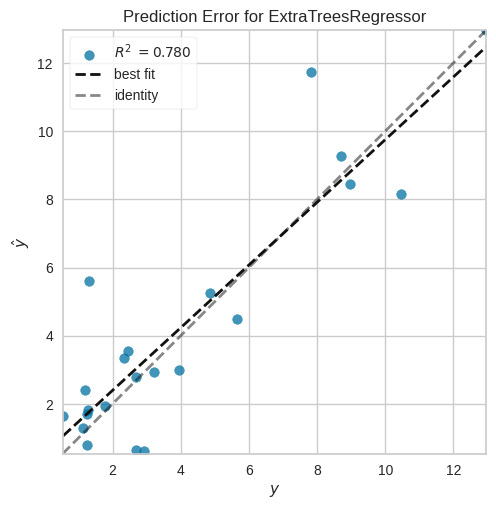

In [48]:
s_sim = RegressionExperiment()
s_sim.setup(
    data=data_sim_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_sim = s_sim.compare_models(turbo=True, sort="MSE")

s_sim.plot_model(best_sim, plot="error")

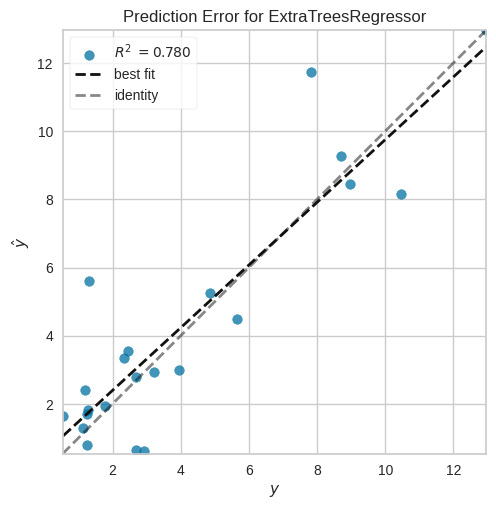

In [49]:
manual_model_sim = s_sim.create_model("et")
s_sim.plot_model(manual_model_sim, plot="error")

## Trotter (Simulation, Noisy)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(108, 11)"
4,Transformed data shape,"(108, 10)"
5,Transformed train set shape,"(86, 10)"
6,Transformed test set shape,"(22, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,1.8353,5.8474,2.3063,0.2355,0.4385,0.9929,0.0110
lr,Linear Regression,1.9358,6.2331,2.3893,0.1361,0.4606,1.1711,0.0120
lar,Least Angle Regression,1.9358,6.2331,2.3893,0.1361,0.4606,1.1711,0.0110
huber,Huber Regressor,1.8289,6.3552,2.4049,0.2966,0.4470,0.9621,0.0120
knn,K Neighbors Regressor,1.8945,7.0219,2.4827,0.3662,0.4877,0.9673,0.0160
et,Extra Trees Regressor,1.9622,7.1642,2.5491,0.2986,0.4943,1.0805,0.0450
lightgbm,Light Gradient Boosting Machine,2.0333,7.3057,2.5369,0.3644,0.5398,1.3002,0.1730
rf,Random Forest Regressor,1.9676,7.5013,2.5906,0.2324,0.4944,1.0485,0.0530
ada,AdaBoost Regressor,2.1847,8.0041,2.6836,0.1586,0.5658,1.6128,0.0170
gbr,Gradient Boosting Regressor,1.8916,8.0417,2.6463,0.1033,0.4926,0.9469,0.0170


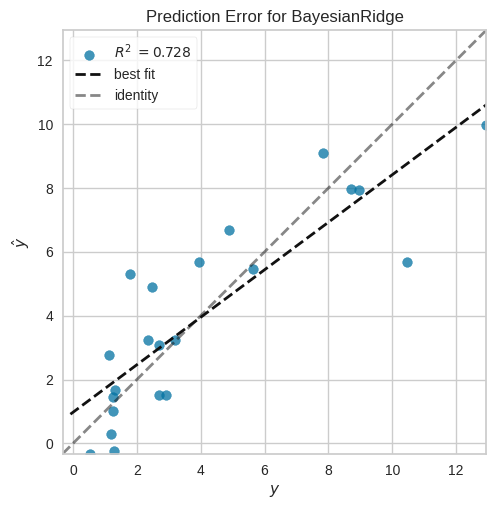

In [50]:
s_sim_noisy = RegressionExperiment()
s_sim_noisy.setup(
    data=data_sim_noisy_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_sim_noisy = s_sim_noisy.compare_models(turbo=True, sort="MSE")
s_sim_noisy.plot_model(best_sim_noisy, plot="error")

## Trotter (QPU, no mitigation)

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(108, 11)"
4,Transformed data shape,"(108, 10)"
5,Transformed train set shape,"(86, 10)"
6,Transformed test set shape,"(22, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,2.2130,8.1039,2.6894,0.1755,0.5151,1.2522,0.0120
lr,Linear Regression,2.2591,8.1073,2.7058,0.1322,0.5231,1.2336,0.0120
lar,Least Angle Regression,2.2591,8.1073,2.7058,0.1322,0.5231,1.2336,0.0090
huber,Huber Regressor,1.8915,8.8375,2.6906,0.3524,0.4541,0.8515,0.0100
et,Extra Trees Regressor,2.2016,9.4599,2.9450,-0.3990,0.5787,1.4723,0.0420
knn,K Neighbors Regressor,2.3009,10.3033,3.0994,-0.2383,0.5838,1.3221,0.0150
gbr,Gradient Boosting Regressor,2.3288,10.7308,3.1807,-0.1153,0.6011,1.3667,0.0170
rf,Random Forest Regressor,2.3714,10.8689,3.1807,-0.2577,0.6180,1.6380,0.0530
ada,AdaBoost Regressor,2.4295,10.9214,3.1805,-0.1846,0.6463,1.9078,0.0170
lightgbm,Light Gradient Boosting Machine,2.5861,11.4646,3.3205,-0.3879,0.6130,1.5626,0.1590


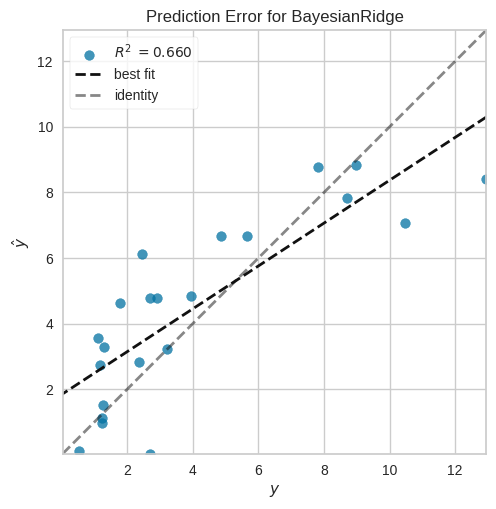

In [51]:
s_nmit = RegressionExperiment()
s_nmit.setup(
    data=data_nmit_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_nmit = s_nmit.compare_models(turbo=True, sort="MSE")
s_nmit.plot_model(best_nmit, plot="error")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:43:59
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5568,5.9679,2.4429,0.3843,0.5873,1.4466
1,1.6207,5.6072,2.3680,0.4180,0.3765,0.7601
2,1.2584,2.3923,1.5467,0.7474,0.4286,0.6748
3,1.7729,6.2442,2.4988,0.6969,0.5317,3.0351
4,1.6753,4.9806,2.2317,0.5506,0.5427,1.4992
5,2.3734,12.1536,3.4862,0.1973,0.5665,0.9186
6,3.6716,21.6515,4.6531,-0.4336,0.6500,0.4843
7,2.7034,10.7826,3.2837,0.6113,0.7377,2.5305
8,2.1637,8.1732,2.8589,-7.3069,0.6805,2.1871


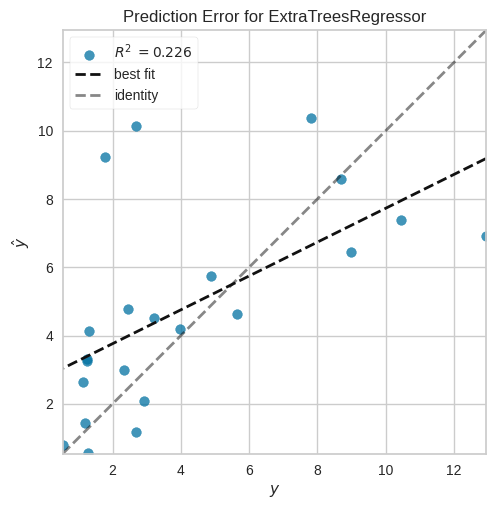

In [52]:
manual_model_nmit = s_nmit.create_model("et")
s_nmit.plot_model(manual_model_nmit, plot="error")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:44:01
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Bayesian Ridge


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5534,2.7570,1.6604,0.7156,0.4932,1.2447
1,2.6796,8.1203,2.8496,0.1572,0.5561,1.7440
2,0.9271,1.2114,1.1006,0.8721,0.2409,0.6668
3,1.7185,5.8669,2.4222,0.7152,0.3971,0.8726
4,2.1886,7.1164,2.6677,0.3578,0.5834,1.6650
5,2.6510,10.9891,3.3150,0.2742,0.5758,1.7311
6,3.2508,18.5422,4.3061,-0.2277,0.5397,0.4950
7,2.4297,10.4858,3.2382,0.6220,0.5303,1.3643
8,1.5817,2.9799,1.7262,-2.0286,0.5376,1.4159


Fitting 10 folds for each of 10 candidates, totalling 100 fits


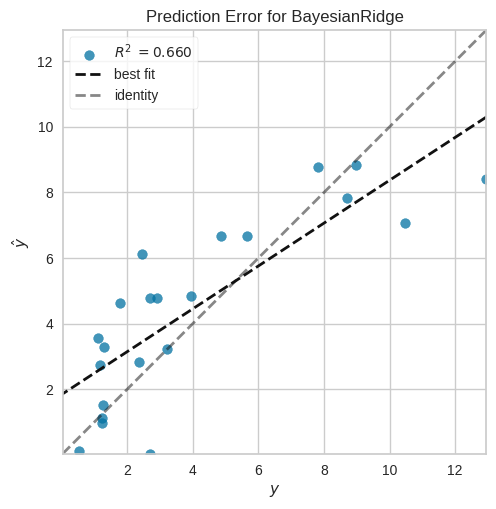

In [53]:
s_nmit.tune_model(best_nmit, optimize="MSE", choose_better=True)
s_nmit.plot_model(best_nmit, plot="error")

## Trotter (QPU, mitigation)

In [54]:
s_mit = RegressionExperiment()
s_mit.setup(
    data=data_mit_df,
    target="expected_value",
    ignore_features="sample_id",
    train_size=train_size,
    session_id=session_id,
)
best_mit = s_mit.compare_models(turbo=True, sort="MSE")

,Description,Value
0,Session id,42
1,Target,expected_value
2,Target type,Regression
3,Original data shape,"(108, 11)"
4,Transformed data shape,"(108, 10)"
5,Transformed train set shape,"(86, 10)"
6,Transformed test set shape,"(22, 10)"
7,Ignore features,9
8,Numeric features,9
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,2.2185,8.1648,2.6971,0.1724,0.5167,1.2535,0.0090
lar,Least Angle Regression,2.2476,8.4486,2.7421,0.1160,0.5155,1.2469,0.0090
lr,Linear Regression,2.2476,8.4487,2.7421,0.1160,0.5155,1.2469,0.0100
huber,Huber Regressor,1.8727,8.8377,2.6843,0.3497,0.4624,0.8595,0.0110
et,Extra Trees Regressor,2.1943,9.2828,2.9281,-0.2981,0.5789,1.5598,0.0420
knn,K Neighbors Regressor,2.3369,10.4214,3.1178,-0.2401,0.5918,1.3542,0.0140
rf,Random Forest Regressor,2.3854,10.4588,3.1301,-0.2720,0.6205,1.7739,0.0550
gbr,Gradient Boosting Regressor,2.3542,10.6126,3.1536,-0.2701,0.6220,1.4582,0.0160
ada,AdaBoost Regressor,2.5074,10.9043,3.1929,-0.1973,0.6697,2.1004,0.0170
lightgbm,Light Gradient Boosting Machine,2.6009,11.1271,3.2623,-0.3322,0.6301,1.8357,0.1780


In [55]:
holdout_pred_mit = s_mit.predict_model(best_mit)
display(holdout_pred_mit)

,f_0 Re,f_1 Re,f_1 Im,f_2 Re,f_2 Im,f_3 Re,f_3 Im,f_4 Re,f_4 Im,expected_value,prediction_label
77,0.896484,0.676032,-0.052285,0.650849,-0.069817,0.653035,-0.046061,0.638061,-0.084846,1.303712,3.278563
10,0.895264,0.660208,-0.035615,0.683370,-0.004292,0.660893,-0.013222,0.657025,0.004841,2.461009,6.071016
4,0.894287,0.590219,-0.337170,0.566662,-0.343257,0.574451,-0.353263,0.538485,-0.365751,1.121292,3.525186
83,0.896729,0.633309,-0.059070,0.631361,-0.111647,0.606533,-0.169223,0.571916,-0.210032,0.538452,0.065565
62,0.885498,0.616736,-0.264343,0.583799,-0.271645,0.590174,-0.303548,0.576060,-0.284877,3.209185,3.266774
67,0.882080,0.579062,-0.264702,0.589364,-0.241069,0.580063,-0.235514,0.580726,-0.177493,10.461210,7.133326
30,0.894043,0.634427,-0.113691,0.599266,-0.168913,0.568512,-0.228954,0.550985,-0.273994,2.697981,-0.002379
45,0.886475,0.546281,-0.387194,0.505117,-0.437042,0.448180,-0.470058,0.368534,-0.507647,2.912899,4.835387
95,0.892822,0.535460,-0.363669,0.546999,-0.361888,0.528871,-0.397138,0.533517,-0.400228,1.185558,2.712701
11,0.895264,0.619842,-0.259771,0.616844,-0.225394,0.620482,-0.183654,0.632262,-0.132499,8.700416,7.806945


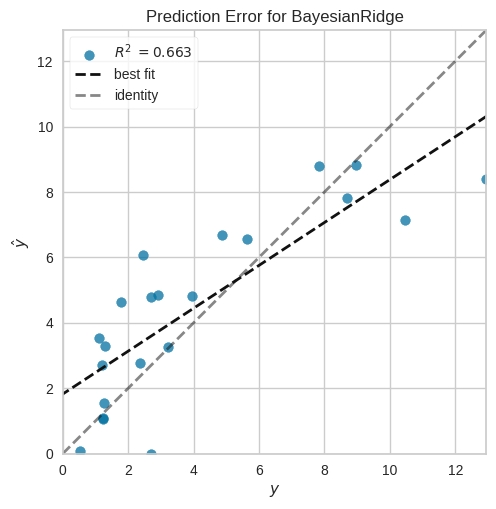

In [56]:
s_mit.plot_model(best_mit, plot="error")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:44:12
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Bayesian Ridge


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5199,2.6586,1.6305,0.7257,0.4898,1.2413
1,2.7015,8.2434,2.8711,0.1444,0.5574,1.7244
2,0.8984,1.1987,1.0948,0.8734,0.2356,0.6226
3,1.7462,5.9601,2.4413,0.7107,0.4029,0.9629
4,2.2135,7.2097,2.6851,0.3494,0.5903,1.7021
5,2.6573,11.0620,3.3260,0.2694,0.5772,1.7378
6,3.2200,18.4056,4.2902,-0.2187,0.5351,0.4845
7,2.4465,10.5515,3.2483,0.6196,0.5301,1.3838
8,1.5798,2.9866,1.7282,-2.0354,0.5366,1.4093


Fitting 10 folds for each of 10 candidates, totalling 100 fits


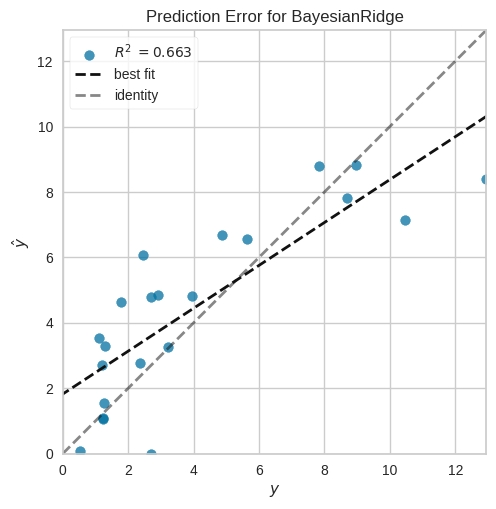

In [57]:
s_mit.tune_model(best_mit, optimize="MSE", choose_better=True)
s_mit.plot_model(best_mit, plot="error")

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,10:44:13
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Extra Trees Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.3995,4.4560,2.1109,0.5403,0.5287,1.2047
1,1.8768,6.5737,2.5639,0.3177,0.4104,0.8072
2,1.3079,2.4970,1.5802,0.7364,0.4465,0.7144
3,1.7470,6.4886,2.5473,0.6850,0.5625,3.8716
4,1.8232,6.3710,2.5241,0.4251,0.5501,1.4660
5,2.3126,12.3128,3.5090,0.1867,0.5719,1.0406
6,3.4283,19.3557,4.3995,-0.2816,0.5948,0.4310
7,2.7281,10.1989,3.1936,0.6324,0.7600,2.7517
8,2.1051,7.2129,2.6857,-6.3309,0.6642,2.1636


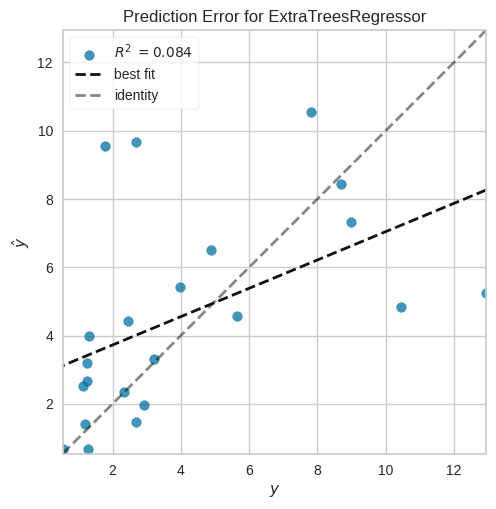

In [58]:
manual_model_mit = s_mit.create_model("et")
s_mit.plot_model(manual_model_mit, plot="error")